<a href="https://colab.research.google.com/github/thddn19/intro_ml_notebooks/blob/main/MLFlow%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_MLOps_%EC%8B%A4%EC%8A%B5_%2B_Azure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --force-install mlflow==1.23.0

In [ ]:
import mlflow 
print(mlflow.__version__)

1.23.0


databricks를 이용할 경우

In [ ]:
!databricks configure --host https://community.cloud.databricks.com/
mlflow.set_tracking_uri("databricks")

mlflow.set_experiment("/Users/thddn19@yonsei.ac.kr/scikit_learn_experiment") # databricks에 experiment가 없는 경우 새로 생성한다.

Colab을 이용할 경우

In [ ]:
# 캐글 접속 후 인증 
!pip install kaggle
from google.colab import files
files.upload()


In [ ]:

# kaggle 데이터 다운로드를 위해 kaggle인증키 파일 복사이동
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d mlg-ulb/creditcardfraud
! unzip creditcardfraud.zip 

 86% 57.0M/66.0M [00:00<00:00, 214MB/s]
100% 66.0M/66.0M [00:00<00:00, 206MB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [ ]:
! pip install --force-reinstall scikit-learn==0.22.1

  Using cached scikit_learn-0.22.1-cp37-cp37m-manylinux1_x86_64.whl (7.0 MB)
  Using cached scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.1 MB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Using cached numpy-1.21.5-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==

In [ ]:
import sklearn
import imp
imp.reload(sklearn)

<module 'sklearn' from '/usr/local/lib/python3.7/dist-packages/sklearn/__init__.py'>

In [ ]:
import sklearn
print(sklearn.__version__)

0.22.1


In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix
from sklearn.model_selection import KFold

import mlflow
import mlflow.sklearn

print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"sklearn: {sklearn.__version__}")
print(f"mlflow: {mlflow.__version__}")

numpy: 1.21.5
pandas: 1.3.5
matplotlib: 3.2.2
seaborn: 0.11.2
sklearn: 0.22.1
mlflow: 1.23.0


In [ ]:
data_path = "./creditcard.csv"
df = pd.read_csv(data_path)
df = df.drop("Time", axis=1)

In [ ]:
normal = df[df.Class==0].sample(frac=0.5, random_state = 100).reset_index(drop=True)
anomaly = df[df.Class==1]

In [ ]:
# train - test 데이터셋 분리
normal_train, normal_test = train_test_split(normal, test_size = 0.2, random_state= 100)
anomaly_train, anomaly_test = train_test_split(anomaly,test_size = 0.2, random_state= 100)

# 80%의 train set내에서 20%차지하도록 25% validation set 으로 분리
normal_train, normal_val = train_test_split(normal_train, test_size = 0.25, random_state = 100)
anomaly_train, anomaly_val = train_test_split(anomaly_train, test_size = 0.25, random_state = 100)

In [ ]:
x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_val = pd.concat((normal_val, anomaly_val))

y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_val = np.array(x_val["Class"])

x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_val = x_val.drop("Class", axis=1)

print(f'train dataset : {x_train.shape}, {y_train.shape}')
print(f'test dataset : {x_test.shape}, {y_test.shape}')
print(f'validation dataset : {x_val.shape}, {y_val.shape}')

train dataset : (85588, 29), (85588,)
test dataset : (28531, 29), (28531,)
validation dataset : (28531, 29), (28531,)


In [ ]:
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop("Class",axis=1))

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

#  MLFlow를 이용한 모델 학습 및 평가

## 모델 학습 및 학습 정확도 지표

In [ ]:
def train(sk_model, x_train, y_train) :
  sk_model = sk_model.fit(x_train, y_train)
  train_acc = sk_model.score(x_train, y_train)

  mlflow.log_metric("train_acc", train_acc)
  
  print(f"Train Accuracy: {train_acc:.3%}")

학습이 진행되며, 학습정확도 지표는 mlflow에 로깅된다.

In [ ]:
def evaluate(sk_model, x_test, y_test) :
  eval_acc = sk_model.score(x_test, y_test)
  preds= sk_model.predict(x_test)
  auc_score = roc_auc_score(y_test, preds)

  mlflow.log_metric("eval_acc", eval_acc)
  mlflow.log_metric("auc_score", auc_score)
  
  print(f"Evaluate Accuracy: {auc_score:.3%}")
  print(f"Accuracy Accuracy: {eval_acc:.3%}")
  roc_plot = plot_roc_curve(sk_model, x_test, y_test, name='scikit_learn ROC Curve')
  plt.savefig("sklearn_roc_plot.png")
  plt.show()
  plt.clf()
  conf_matrix = confusion_matrix(y_test, preds)
  ax = sns.heatmap(conf_matrix, annot=True, fmt='g')
  ax.invert_xaxis()
  ax.invert_yaxis()
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.savefig("sklearn_conf_matrix.png")

  mlflow.log_artifact("sklearn_roc_plot.png")
  mlflow.log_artifact("sklearn_conf_matrix.png")


평가지표 및 Confusion Matrix, ROC 곡선에 대한 그림이 생성되며, 그래프와 지표 모두 MLFlow에 로깅된다.

##  MLFlow 실행 로깅 및 확인

실제로 실행시켜보자

Train Accuracy: 99.884%
Evaluate Accuracy: 87.361%
Accuracy Accuracy: 99.888%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


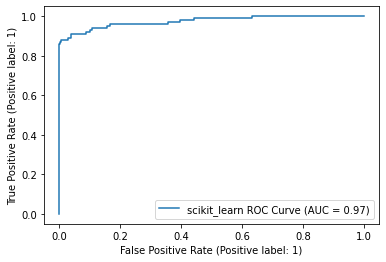

model run :  3427cabfd81d4d8fa090a9f95565e52a


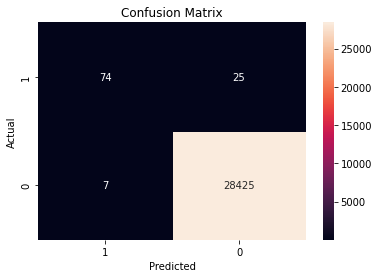

In [ ]:
sk_model = LogisticRegression(max_iter = 400, solver='newton-cg')
mlflow.set_experiment("/Users/thddn19@yonsei.ac.kr/scikit_learn_experiment") # expriment 설정, 없는 경우 새로 생성
with mlflow.start_run():  # expreiment 생성하면서 실행되는 코드
  train(sk_model, x_train, y_train)
  evaluate(sk_model, x_test, y_test)
  mlflow.sklearn.log_model(sk_model, "log_reg_model") # 모델 로깅 시에 사용되는 일반적인 규칙이며 저장되는 모델과 모델명을 설정한다.
  print("model run : ", mlflow.active_run().info.run_uuid)
mlflow.end_run() 

https://community.cloud.databricks.com/ 에 접속해서 확인하면 지표와 지표를 기반으로 생성한 이미지들을 확인할 수 있다.

## 저장한 모델 다시 가져오기

In [ ]:
loaded_model = mlflow.sklearn.load_model("runs:/b95e615c15e14ed69b6cca4c11f7eb04/log_reg_model") # 로깅 root 폴더 이름이며, experiment 생성 시에 지정할 수 있었다.

가져온 모델의 정확도를 측정해보자

In [ ]:
loaded_model.score(x_test, y_test)

0.9988784129543303

반올림까지 무시하고 어느 정도 일치하는 것을 알 수 있다.

이부분 까지가 파이프라인을 재현, 테스트하고 검증하는데 필요한 부분을 준비하였다.

# MLFlow를 사용한 모델 검증(파라미터 튜닝)

## 파라미터 튜닝 - Broad Search
앞서 위에서 진행한 모델 검증 스크립트는 대부분 동일하지만, MLFlow 몇 개 추가하였다.

In [ ]:
anomaly_weights = [1,5,10,15]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 100)

In [ ]:
mlflow.set_experiment("/Users/thddn19@yonsei.ac.kr/sklearn_creditcard_broad_search")
logs = []
for i in range(len(anomaly_weights)):
  fold = 1
  accuracies = []
  auc_scores = []
  for train, test in kfold.split(x_val, y_val):
    with mlflow.start_run() : 
      weight = anomaly_weights[i]
      mlflow.log_param("anomaly_weight", weight)
      class_weights= {
          0: 1,
          1: weight
      }
      sk_model = LogisticRegression(random_state = None, 
                                     max_iter = 400,
                                     solver = 'newton-cg',
                                     class_weight=class_weights).fit(x_val[train], y_val[train])
      for j in range(40): print('-', end = "")
      print(f"\n fold {fold} \n Anomaly Weight: {weight}")
      train_acc = sk_model.score(x_val[train], y_val[train])
      mlflow.log_metric("trian_acc", train_acc)
      eval_acc = sk_model.score(x_val[test], y_val[test])
      preds = sk_model.predict(x_val[test])

      mlflow.log_metric("eval_acc", eval_acc)

      try :
        auc_score = roc_auc_score(y_val[test], preds)
      except :
        auc_score = -1

      mlflow.log_metric("auc_score", auc_score)

      print(f"AUC: {auc_score}\n eval_acc: {eval_acc}")

      accuracies.append(eval_acc)
      auc_scores.append(auc_score)

      log = [sk_model, x_val[test], y_val[test], preds]
      logs.append(log)
      mlflow.sklearn.log_model(sk_model, f"anom_weight_{weight}_fold_{fold}")
      fold+=1
      mlflow.end_run()

----------------------------------------
 fold 1 
 Anomaly Weight: 1
AUC: 0.924648320731493
 eval_acc: 0.9987734361310671
----------------------------------------
 fold 2 
 Anomaly Weight: 1
AUC: 0.7856263349667044
 eval_acc: 0.9982474588152822
----------------------------------------
 fold 3 
 Anomaly Weight: 1
AUC: 0.7856263349667044
 eval_acc: 0.9982474588152822
----------------------------------------
 fold 4 
 Anomaly Weight: 1
AUC: 0.815613634049957
 eval_acc: 0.998422712933754
----------------------------------------
 fold 5 
 Anomaly Weight: 1
AUC: 0.9164908579465543
 eval_acc: 0.999123729407641
----------------------------------------
 fold 1 
 Anomaly Weight: 5
AUC: 0.9245604009143662
 eval_acc: 0.9985982127212195
----------------------------------------
 fold 2 
 Anomaly Weight: 5
AUC: 0.8329815303430078
 eval_acc: 0.9980722046968104
----------------------------------------
 fold 3 
 Anomaly Weight: 5
AUC: 0.8570549063952759
 eval_acc: 0.9987732211706976
--------------------

In [ ]:
print("\n Averages :")
print(f"Accuracy: {np.mean(accuracies)}")
print("Best: ")
print(f"Accuracy: {np.max(accuracies)}")
print(f"AUC: {np.max(auc_scores)}" )


 Averages :
Accuracy: 0.9976166299729317
Best: 
Accuracy: 0.9980722046968104
AUC: 0.9709036568213782


다시 https://community.cloud.databricks.com/ 에서 생성한 expriment를 확인해보면 auc 점수를 확인 할 수 있다.

In [ ]:
# metrics."auc_score" >= 0.9 

SQL절을 따르는데 0.9이상의 값들만 필터링 할 수 있다.

In [ ]:
# metrics."auc_score" >= 0.9 AND param.anomaly_weight = "5" 
# metrics."auc_score" >= 0.9 AND param.anomaly_weight = "10" 

# metrics."auc_score" >= 0.95 AND param.anomaly_weight = "5" 
# metrics."auc_score" >= 0.95 AND param.anomaly_weight = "10" 
# metrics."auc_score" >= 0.95 AND param.anomaly_weight = "15" 

# param.anomaly_weight = "1" 

AND연산자를 이용해 특정 가중치에 대해 AUC 점수를 확인할 수 있다. 적절한 가중치 판단은 평균 AUC 점수를 기준으로 삼았다.

## 파라미터 튜닝 - Guided Search
이상 가중치에 대해 살펴본 결과 적절한 가중치라고 생각되는 값을 찾지 못 했다.
<br>
이상 가중치 범위를 좀 더 늘리고, 첫번째 experiment 결과를 유지하기 위해 다시 생성해보자

In [ ]:
anomaly_weights = [10,50,100,150, 200]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 100)

In [ ]:
mlflow.set_experiment("/Users/thddn19@yonsei.ac.kr/sklearn_creditcard_guided_search")
logs = []
for i in range(len(anomaly_weights)):
  fold = 1
  accuracies = []
  auc_scores = []
  for train, test in kfold.split(x_val, y_val):
    with mlflow.start_run() : 
      weight = anomaly_weights[i]
      mlflow.log_param("anomaly_weight", weight)
      class_weights= {
          0: 1,
          1: weight
      }
      sk_model = LogisticRegression(random_state = None, 
                                     max_iter = 400,
                                     solver = 'newton-cg',
                                     class_weight=class_weights).fit(x_val[train], y_val[train])
      for j in range(40): print('-', end = "")
      print(f"\n fold {fold} \n Anomaly Weight: {weight}")
      train_acc = sk_model.score(x_val[train], y_val[train])
      mlflow.log_metric("trian_acc", train_acc)
      eval_acc = sk_model.score(x_val[test], y_val[test])
      preds = sk_model.predict(x_val[test])

      mlflow.log_metric("eval_acc", eval_acc)

      try :
        auc_score = roc_auc_score(y_val[test], preds)
      except :
        auc_score = -1

      mlflow.log_metric("auc_score", auc_score)

      print(f"AUC: {auc_score}\n eval_acc: {eval_acc}")

      accuracies.append(eval_acc)
      auc_scores.append(auc_score)

      log = [sk_model, x_val[test], y_val[test], preds]
      logs.append(log)
      mlflow.sklearn.log_model(sk_model, f"anom_weight_{weight}_fold_{fold}")
      fold+=1
      mlflow.end_run()

----------------------------------------
 fold 1 
 Anomaly Weight: 10
AUC: 0.9491208018287322
 eval_acc: 0.9978973190818293
----------------------------------------
 fold 2 
 Anomaly Weight: 10
AUC: 0.8326297273526825
 eval_acc: 0.9973711882229233
----------------------------------------
 fold 3 
 Anomaly Weight: 10
AUC: 0.8806005779620555
 eval_acc: 0.998422712933754
----------------------------------------
 fold 4 
 Anomaly Weight: 10
AUC: 0.8416656640722607
 eval_acc: 0.9980722046968104
----------------------------------------
 fold 5 
 Anomaly Weight: 10
AUC: 0.9712552742616034
 eval_acc: 0.9978969505783386
----------------------------------------
 fold 1 
 Anomaly Weight: 50
AUC: 0.9470986460348162
 eval_acc: 0.9938671806553355
----------------------------------------
 fold 2 
 Anomaly Weight: 50
AUC: 0.9016836285965574
 eval_acc: 0.9931650893796005
----------------------------------------
 fold 3 
 Anomaly Weight: 50
AUC: 0.9027390375675336
 eval_acc: 0.9952681388012619
---------

In [ ]:
print("\n Averages :")
print(f"Accuracy: {np.mean(accuracies)}")
print("Best: ")
print(f"Accuracy: {np.max(accuracies)}")
print(f"AUC: {np.max(auc_scores)}" )


 Averages :
Accuracy: 0.9783042280063758
Best: 
Accuracy: 0.9826498422712934
AUC: 0.9871659634317862


이후 다시 필터링으로 가중치를 살펴보자

In [ ]:
# param.anomaly_weight = "5" 
# param.anomaly_weight = "50" 
# param.anomaly_weight = "100" 
# param.anomaly_weight = "150" 
# param.anomaly_weight = "200" 

AUC 점수가 가중치값과 비례관계를 갖고 있다는 것을 고려해야하기는 하지만, 200이 가장 적절한 값이었다.

# MLFlow 및 TensorFlow 2.0(Keras)
MNIST손글씨 dataset을 이용해 MLFlow 테스트를 진행한다.
사이킷런 라이브러와 비슷하다.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import roc_auc_score
import mlflow
import mlflow.tensorflow

print(f"TensorFlow: {tf.__version__}")
print(f"MLFlow: {mlflow.__version__}")

TensorFlow: 2.8.0
MLFlow: 1.23.0


In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


Class:  5


(<matplotlib.image.AxesImage at 0x7f2a6ee42790>, None)

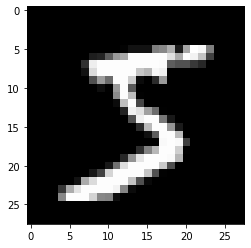

In [ ]:
plt.imshow(x_train[0], cmap='gray'), print("Class: ", y_train[0])

한편, CNN은 샘플수, 높이, 너비, 채널을 인자로 받기 때문에 데이터를 다시 구성해야한다. <br>

y값 또한 원-핫 인코딩 형식으로 변환하자.

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1) # 흑백이므로 1
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1) 

print(f"x_train_shape: {x_train.shape}")  # x_train_shape: (60000, 28, 28, 1)
print(f"x_test_shape: {x_test.shape}")  # x_test_shape: (10000, 28, 28, 1)

x_train_shape: (60000, 28, 28, 1)
x_test_shape: (10000, 28, 28, 1)


In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, 10)  # 원-핫 인코딩. 1차원 -> 2차원
y_test = tf.keras.utils.to_categorical(y_test, 10)

print(f"y_train_shape: {y_train.shape}")  # y_train_shape: (60000, 10)
print(f"y_test_shape: {y_test.shape}")  # y_test_shape: (10000, 10)

y_train_shape: (60000, 10)
y_test_shape: (10000, 10)


## MLFlow 실행 - 학습 및 평가
이미지이므로 CNN 모델을 생성하자

In [ ]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, strides=2, padding='same', input_shape=(28,28,1), activation='relu'))
model.add(Conv2D(filters=8, kernel_size=3, strides=2, padding='same', input_shape=(28,28,1), activation='relu'))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense (Dense)               (None, 30)                11790     
                                                                 
 dense_1 (Dense)             (None, 20)                620       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
Total params: 13,940
Trainable params: 13,940
Non-traina

다음 Adam Optimizer를 사용, 손실함수는 Categorical_crossentropy

In [ ]:
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

이제 MLFlow를 이용해 모델을 저장 및 로깅해보자

In [ ]:
mlflow.set_experiment("/Users/thddn19@yonsei.ac.kr/TF_Keras_MNIST")
with mlflow.start_run():  
  mlflow.tensorflow.autolog() # 이 부분이 추가되었는데, 모델과 관련된 모든 파라미터와 지표를 기록하도록 한다.
  model.fit(x_train, y_train, batch_size=256, epochs = 10)
  preds = np.round(model.predict(x_test))
  eval_acc = model.evaluate(x_test, y_test)[1]
  auc_score = roc_auc_score(y_test, preds)

  print(f"eval_acc: {eval_acc}")
  print(f"auc_score: {auc_score}")

  mlflow.tensorflow.mlflow.log_metric("eval_acc", eval_acc)
  mlflow.tensorflow.mlflow.log_metric("auc_score", auc_score)
mlflow.end_run() 

2022/03/28 09:28:45 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


Epoch 1/10
235/235 [==============================] - 9s 34ms/step - loss: 1.2203 - accuracy: 0.6515
Epoch 2/10
235/235 [==============================] - 9s 37ms/step - loss: 0.2443 - accuracy: 0.9279
Epoch 3/10
235/235 [==============================] - 8s 33ms/step - loss: 0.1574 - accuracy: 0.9528
Epoch 4/10
235/235 [==============================] - 8s 34ms/step - loss: 0.1172 - accuracy: 0.9644
Epoch 5/10
235/235 [==============================] - 9s 36ms/step - loss: 0.0960 - accuracy: 0.9701
Epoch 6/10
235/235 [==============================] - 9s 39ms/step - loss: 0.0812 - accuracy: 0.9754
Epoch 7/10
235/235 [==============================] - 8s 33ms/step - loss: 0.0703 - accuracy: 0.9783
Epoch 8/10
235/235 [==============================] - 8s 33ms/step - loss: 0.0640 - accuracy: 0.9800
Epoch 9/10
235/235 [==============================] - 8s 33ms/step - loss: 0.0575 - accuracy: 0.9814
Epoch 10/10
235/235 [==============================] - 8s 33ms/step - loss: 0.0532 - accura

2022/03/28 09:30:18 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.2+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLflow logged a pip requirement for this package as 'jaxlib==0.3.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


313/313 [==============================] - 2s 7ms/step - loss: 0.0714 - accuracy: 0.9780
eval_acc: 0.9779999852180481
auc_score: 0.9869752220446607


다시 databricks 커뮤니티에 들어가서 확인하면 정상적으로 기록 된 것을 볼 수 있다.

## MLFlow에 저장한 모델 다시 불러오기

In [ ]:
loaded_model = mlflow.keras.load_model("runs:/498bb410cbeb47e29f5869be2ab9270b/model") # RUN_ID, 따로 이름 설정하지 않았다면 model이 default

In [ ]:
eval_loss, eval_acc = loaded_model.evaluate(x_test, y_test)
pred = np.round(loaded_model.predict(x_test))
eval_auc = roc_auc_score(y_test, preds)
print("Eval Loss:", eval_loss) 
print("Eval Acc:", eval_acc)
print("Eval AUC:", eval_auc)

313/313 [==============================] - 2s 5ms/step - loss: 0.1268 - accuracy: 0.9803
Eval Loss: 0.12675032019615173
Eval Acc: 0.9803000092506409
Eval AUC: 0.9869752220446607


평가지표를 보면 저장할 때의 모델과 비슷하다는 것을 알 수 있다.

# MLFlow와 PyTorch, PySpark
문법은 조금씩 다르지만, 전체적인 흐름은 거의 비슷하다.

# 모델 서빙 및 배포 (Azure, databricks)
databricks에 experiment를 저장 및 notebook실행, Azure workspace에서는 model registry와 model deployment를 진행하도록 하는 설정이다.
책에서 진행한 과정이며, 책에 나온 버전대로 잘 맞춰줘야하고, 그렇지 않을 경우 실패한다.

In [ ]:
! pip install azureml-sdk

In [ ]:
import azureml
from azureml.core import Workspace
workspace_name = "songmlopswork"
workspace_location = "koreacentral"
resource_group = "song_mlops"
subscription_id = "XXXXXXX-XXXX"

workspace = Workspace.create(name = workspace_name,
                            location = workspace_location,
                            resource_group = resource_group,
                            subscription_id = subscription_id,
                            exist_ok = True)

In [ ]:
run_id = 'b95e615c15e14ed69b6cca4c11f7eb04'
model_name = "log_reg_model"
model_uri = f"runs:/{run_id}/{model_name}"

In [ ]:
import mlflow.azureml
model_image, azure_model = mlflow.azureml.build_image (model_uri = model_uri, workspace=workspace, model_name="log_reg_model", image_name="model", description="sklearn logreg model for description", synchronous=False)
model_image.wait_for_creation(show_output=True)

In [ ]:
model_uri = 'runs:/b95e615c15e14ed69b6cca4c11f7eb04/log_reg_model' 

In [ ]:
azure_service, azure_model  = mlflow.azureml.deploy(model_uri, workspace, service_name="sklearn-creditcardfraud-srvc1", model_name="sklearn_creditcard_model1")

In [ ]:
azure_service.scoring_uri

In [ ]:
import requests
import json
def query(scoring_uri, inputs) :
    headers = {
        "Content-Type": "application.json",
    }
    response = requests.post(scoring_uri, data=inputs,
                            headers=headers)
    headers=headers,
    preds = json,

# 모델 등록 및 배포하기 (Azure, Azure Notebook)
Azure notebook에 ipynb로 export하는 칸이 따로 없어서 그냥 참고용으로 붙인다.

## 모델 등록

In [ ]:
model_uri = "runs:/{}/model".format(run.info.run_id)
model = mlflow.register_model(model_uri, "sklearn_creditcard_model")

In [ ]:
model.id = 'sklearn_creditcard_model:6'

## 모델 배포
Azure환경에서는 배포까지 성공했다. <br>
다만, inferenceConfig클래스에 사용되는 entry_script를 설정할 때 score.py의 init, run을 어떻게 구성해야할지 모르겠어서 좀 더 공부하고 진행하기로 했다.

In [ ]:
# 배포를 위한 환경설정
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.webservice import AciWebservice

# 엔드포인트 처리 컴퓨팅 사양 설정
env = Environment.get(
    workspace=ws, 
    name="AzureML-sklearn-0.24.1-ubuntu18.04-py37-cpu-inference",
    version=1
)
env.inferencing_stack_version='latest'

# 배포 관련 설정 i.e. compute resources
aciconfig = AciWebservice.deploy_configuration(
    cpu_cores=1,
    memory_gb=1,
    tags={"data": "kaggle_CreaditCard", "method": "sklearn"},
    description="Predict CreditCard fraud with sklearn",
)


In [ ]:
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment
from azureml.core.model import Model


# 추론 설정 i.e. the scoring script and environment
inference_config = InferenceConfig(entry_script="echo_score.py", environment=env)

# 서비스 배포
service_name = "sklearn-creditcardfraud-srvc"
service = Model.deploy(
    workspace=ws,
    name=service_name,
    models=[model],
    inference_config=inference_config,
    deployment_config=aciconfig,
    overwrite=True
)

service.wait_for_deployment(show_output=True)

In [ ]:
# 서비스 배포 관련 로그 출력
print(service.get_logs())

In [ ]:
# 엔드포인트 종료 및 삭제
service.delete()

# 정리
MLOps원칙을 통합해 다양한 프레임워크를 지원하는 API인 MLFlow를 이용해 지표, 파라미터, 그래프 및 모델 자체를 로깅하는 방법에 대해 알아봤다.